# Fake News Detection- 1
Fake news detection using NLP and RNN approach 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import PorterStemmer
import re
from nltk.corpus import stopwords

from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Loading Dataset

In [2]:
train_df = pd.read_csv('../DataSets/train.csv')
test_df =   pd.read_csv('../DataSets//test.csv')

In [3]:
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
test_df.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


## Handling Null Values

In [6]:
train_df = train_df.fillna('')
test_df = test_df.fillna('')

In [7]:
train_df.isna().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [8]:
test_df.isna().sum()

id        0
title     0
author    0
text      0
dtype: int64

### Concatenating the title, the author and the main text to make the model more generalised and increasing the reliability of the model

In [9]:
train_df['total'] = train_df['title'] + train_df['author']
test_df['total'] = test_df['title'] + test_df['author']

In [10]:
fake_count =len(train_df[train_df['label']==1])
real_count = len(train_df[train_df['label']== 0])

### VIsualizing the fake and real news counts

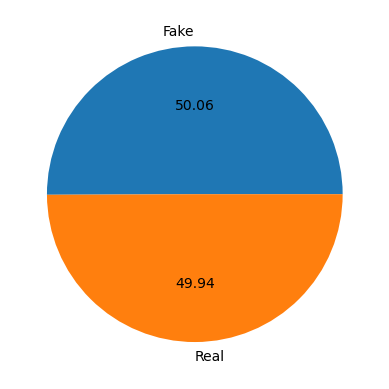

In [11]:
y = np.array([fake_count,real_count])
mylabels = ['Fake','Real']
plt.pie(y,labels=mylabels,autopct='%.2f')
plt.show()

In [12]:
train_df['len_text'] = train_df['text'].apply(lambda x : len(x))

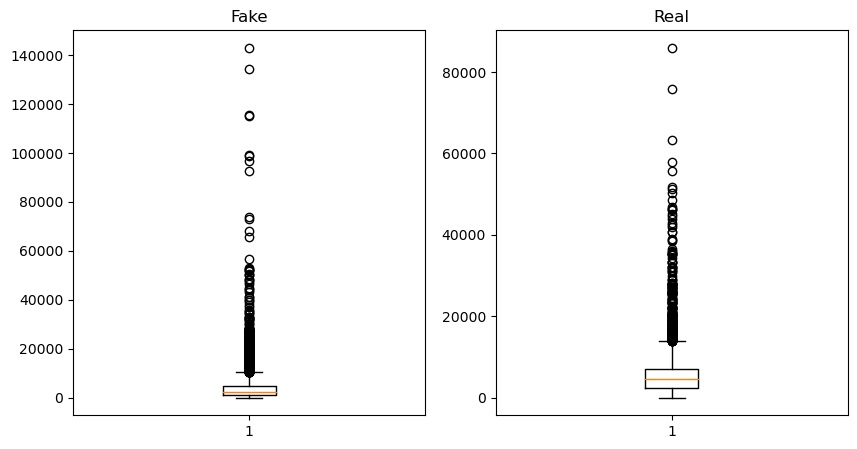

In [13]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.boxplot(train_df[train_df['label']==1]['len_text'])
ax1.set_title('Fake')
ax2.boxplot(train_df[train_df['label']==0]['len_text'])
ax2.set_title('Real')

plt.show()

#####  Observation -  Fake news generally includes less words than Real news

### Visualizing the 'author' column with respect to posted Fake news

<AxesSubplot:xlabel='Author'>

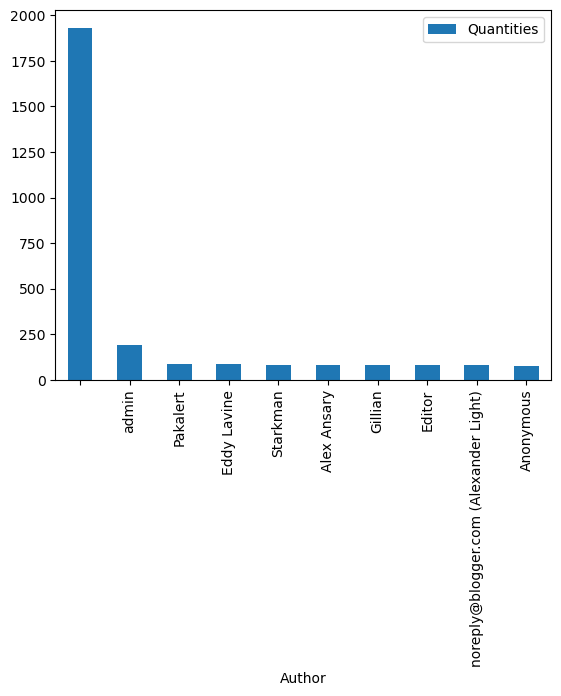

In [14]:
fake_author = pd.DataFrame({'Author':train_df[train_df['label']==1]['author'].value_counts().head(10).index,'Quantities':train_df[train_df['label']==1]['author'].value_counts().head(10)})

fake_author.plot(kind='bar',x='Author',y='Quantities')

### ### Visualizing the 'author' column with respect to posted Real news

<AxesSubplot:xlabel='Author'>

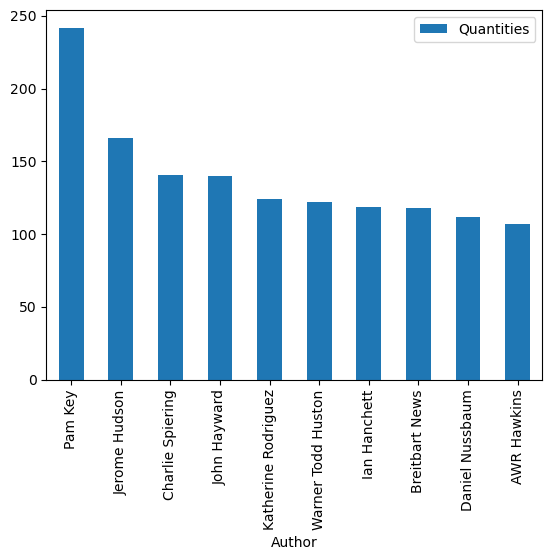

In [15]:
real_author = pd.DataFrame({'Author':train_df[train_df['label']==0]['author'].value_counts().head(10).index,'Quantities':train_df[train_df['label']==0]['author'].value_counts().head(10)})

real_author.plot(kind='bar',x='Author',y='Quantities')

### Dropping all the unneccesary columns

In [16]:
train_df = train_df.drop(columns= ['id','title','author','len_text'])

In [17]:
test_df = test_df.drop(columns = ['title','author'])

In [18]:
ps = PorterStemmer()
def preprocess(data):
    
    filtering = re.sub('[^a-zA-Z]',' ',data) 
    filtering = filtering.lower()
    filtering = filtering.split()
    filtering = [ps.stem(words) for words in filtering if words not in stopwords.words('english') and words.isalpha()]
    filtering = ' '.join(filtering)
    return filtering

In [19]:
train_df['filtered_total'] = train_df['total'].apply(preprocess)
test_df['filtered_total'] = test_df['total'].apply(preprocess)

##### Wordcloud of most common words in Real news 

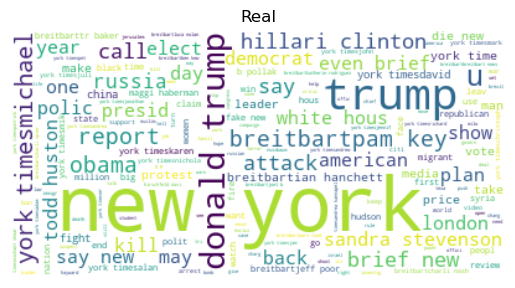

In [20]:
wc1= WordCloud(background_color = 'white')
wc1.generate(' '.join(train_df[train_df['label']==0]['filtered_total']))
plt.imshow(wc1,interpolation = 'bilinear')
plt.title('Real')
plt.axis('off')
plt.show()

##### Wordcloud of most common words in Fake news 

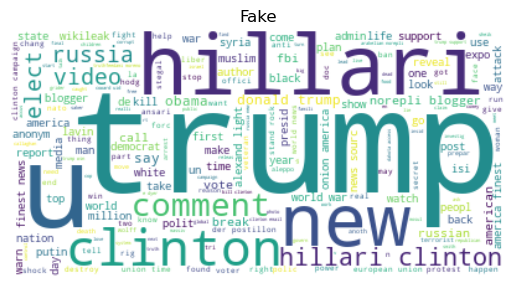

In [21]:
wc = WordCloud(background_color = 'white')
wc.generate(' '.join(train_df[train_df['label']==1]['filtered_total']))
plt.imshow(wc,interpolation = 'bilinear')
plt.title('Fake')
plt.axis('off')
plt.show()

### Filtering the required words using NLP that are crucial to differentiate between Real or Fake news

In [22]:
training = pd.read_csv('../DataSets/train.csv')

In [23]:
fake_title = training[training['label']==1]['title']
real_title = training[training['label']==0]['title']

In [24]:
fake_wordcloud = pd.Series(' '.join([str(i) for i in fake_title ]).split()).value_counts().head(20).index

In [25]:
real_wordcloud = pd.Series(' '.join([str(i) for i in real_title]).split()).value_counts().head(20).index

In [26]:
final_wordcloud = set(fake_wordcloud).intersection(real_wordcloud)

In [27]:
def word_cleaning(data):
    review = [i for i in data.split() if i not in final_wordcloud ]
    return review

In [28]:
train_df['filtered_total'] = train_df['filtered_total'].apply(word_cleaning)
test_df['filtered_total'] = test_df['filtered_total'].apply(word_cleaning)

In [29]:
final_wordcloud

{'Is', 'The', 'Trump', 'a', 'and', 'for', 'in', 'of', 'on', 'the', 'to'}

In [30]:
np.max(train_df['filtered_total'].apply(lambda x: len(x)))

50

In [31]:
sentence_length = 25
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['filtered_total'])
train_df_total = tokenizer.texts_to_sequences(train_df['filtered_total'])
train_df_total = pad_sequences(train_df_total,maxlen = sentence_length)
test_df_total = tokenizer.texts_to_sequences(test_df['filtered_total'])
test_df_total = pad_sequences(test_df_total,maxlen = sentence_length)

In [32]:
test_df_total.shape

(5200, 25)

### Defining the layers of the RNN model 

In [33]:
def create_model(learning_rate):
  
    opt = Adam(lr = learning_rate)
    embedding_vector_features=40
    model = Sequential()
    model.add(Embedding(60000,embedding_vector_features,input_length=sentence_length))
    model.add(Dropout(0.3))
    model.add(LSTM(100))
    model.add(Dropout(0.3))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=opt ,metrics=['accuracy'])
    return model

In [34]:
model = KerasClassifier(build_fn = create_model)

early_stop = EarlyStopping(
    monitor = 'val_loss', min_delta = 0.1, patience = 5, verbose = 0)
callbacks = [early_stop]
params = {'learning_rate' : [0.1, 0.01, 0.001],'batch_size': [64],'callbacks':callbacks,'epochs' :[50]}
random_search = RandomizedSearchCV(model, param_distributions = params,cv = KFold(3), n_jobs = -1,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='min')

C:\Users\USER\AppData\Local\Temp\ipykernel_6860\1605364251.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = create_model)


In [35]:
X = train_df_total
y = train_df['label']

### Splitting the data

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [37]:
    opt = Adam(lr = 0.001)
    embedding_vector_features=40
    model = Sequential()
    model.add(Embedding(60000,embedding_vector_features,input_length=sentence_length))
    model.add(Dropout(0.3))
    model.add(LSTM(100))
    model.add(Dropout(0.3))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=opt ,metrics=['accuracy'])

C:\Users\USER\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 40)            2400000   
                                                                 
 dropout (Dropout)           (None, 25, 40)            0         
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [39]:
history = model.fit(X_train,y_train, validation_data = (X_test,y_test),callbacks = [early_stop,reduce_lr],epochs = 50,batch_size = 64)

Epoch 1/50
218/218 [==============================] - 17s 64ms/step - loss: 0.2389 - accuracy: 0.8841 - val_loss: 0.0415 - val_accuracy: 0.9866 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 14s 64ms/step - loss: 0.0192 - accuracy: 0.9943 - val_loss: 0.0316 - val_accuracy: 0.9897 - lr: 0.0010
Epoch 3/50
218/218 [==============================] - 15s 67ms/step - loss: 0.0051 - accuracy: 0.9988 - val_loss: 0.0431 - val_accuracy: 0.9879 - lr: 0.0010
Epoch 4/50
218/218 [==============================] - 14s 62ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0431 - val_accuracy: 0.9898 - lr: 0.0010
Epoch 5/50
218/218 [==============================] - 14s 63ms/step - loss: 5.3830e-04 - accuracy: 0.9999 - val_loss: 0.0502 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 6/50
218/218 [==============================] - 14s 62ms/step - loss: 5.2568e-04 - accuracy: 0.9999 - val_loss: 0.0422 - val_accuracy: 0.9902 - lr: 0.0010


In [40]:
print('The accuracy of our model is {}'.format(model.evaluate(X_test,y_test)[1]))

215/215 [==============================] - 1s 4ms/step - loss: 0.0422 - accuracy: 0.9902
The accuracy of our model is 0.9902389049530029


In [41]:
preds = model.predict(X_test)
preds

215/215 [==============================] - 1s 4ms/step


array([[9.9999958e-01],
       [9.9993259e-01],
       [1.4003672e-08],
       ...,
       [6.7778907e-05],
       [7.3964943e-06],
       [9.2294849e-03]], dtype=float32)

In [42]:
preds = preds.reshape(-1)
preds.tolist()
preds = [1 if x > 0.5 else 0 for x in preds]

### Classification report of the model

In [43]:
target_names = ['label 0', 'label 1']
print(classification_report(y_test, preds, target_names=target_names))

              precision    recall  f1-score   support

     label 0       0.99      0.99      0.99      3449
     label 1       0.99      0.99      0.99      3415

    accuracy                           0.99      6864
   macro avg       0.99      0.99      0.99      6864
weighted avg       0.99      0.99      0.99      6864



### Training accuracy of 99% is achieved

In [44]:
model.save('rnn_news_detector.model')

INFO:tensorflow:Assets written to: rnn_news_detector.model\assets


INFO:tensorflow:Assets written to: rnn_news_detector.model\assets


### Making predictions on the test data

In [45]:
test_pred = model.predict(test_df_total)
test_pred = [1 if x > 0.5 else 0 for x in test_pred]

163/163 [==============================] - 1s 4ms/step


In [46]:
test_df['label'] = test_pred

In [47]:
test_df

,id,text,total,filtered_total,label
0,20800,"PALO ALTO, Calif. — After years of scorning...","Specter of Trump Loosens Tongues, if Not Purse...","[specter, trump, loosen, tongu, purs, string, ...",0
1,20801,Russian warships ready to strike terrorists ne...,Russian warships ready to strike terrorists ne...,"[russian, warship, readi, strike, terrorist, n...",1
2,20802,Videos #NoDAPL: Native American Leaders Vow to...,#NoDAPL: Native American Leaders Vow to Stay A...,"[nodapl, nativ, american, leader, vow, stay, w...",1
3,20803,"If at first you don’t succeed, try a different...","Tim Tebow Will Attempt Another Comeback, This ...","[tim, tebow, attempt, anoth, comeback, time, b...",0
4,20804,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,Keiser Report: Meme Wars (E995)Truth Broadcast...,"[keiser, report, meme, war, e, truth, broadcas...",1
...,...,...,...,...,...
5195,25995,Of all the dysfunctions that plague the world’...,The Bangladeshi Traffic Jam That Never Ends - ...,"[bangladeshi, traffic, jam, never, end, new, y...",0
5196,25996,WASHINGTON — Gov. John Kasich of Ohio on Tu...,John Kasich Signs One Abortion Bill in Ohio bu...,"[john, kasich, sign, one, abort, bill, ohio, v...",0
5197,25997,Good morning. (Want to get California Today by...,"California Today: What, Exactly, Is in Your Su...","[california, today, exactli, sushi, new, york,...",0
5198,25998,« Previous - Next » 300 US Marines To Be Deplo...,300 US Marines To Be Deployed To Russian Borde...,"[us, marin, deploy, russian, border, norway]",1


### Creating the submission file named rnn_detections.csv

In [48]:
detections = test_df[['id','label']]
detections.head()

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1


In [49]:
detections.to_csv('rnn_detections.csv',index=False)
detections

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1
...,...,...
5195,25995,0
5196,25996,0
5197,25997,0
5198,25998,1
